In [39]:
import gymnasium as gym
import pygame
from gymnasium.utils.play import play
# from gynasium.utils.play import pl
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import random

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'



In [15]:
env = gym.make("CartPole-v1",render_mode="human")

In [94]:
class V_Network(nn.Module):
    def __init__(self):
        super(V_Network, self).__init__()
        self.network = nn.Sequential(nn.Linear(4,24),
                                     nn.Tanh(),
                                     nn.Linear(24,16),
                                     nn.Tanh(),
                                     nn.Linear(16,1))
    def forward(self,state):
            return self.network(state)

class Policy_Network(nn.Module):
    def __init__(self):
        super(Policy_Network, self).__init__()
        self.network = nn.Sequential(nn.Linear(4,24),
                                     nn.ReLU(),
                                     nn.Linear(24,16),
                                     nn.ReLU(),
                                     nn.Linear(16,2),
                                     nn.Softmax(dim=0))
    def forward(self,state):
            return self.network(state)

In [95]:
# @torch.no_grad()
def train(epochs,lrQ,lrP,N_t,model_Q,model_P,max_steps,gamma,opt_func=torch.optim.Adam):
    epsilon =1e-5
    env = gym.make("CartPole-v1",render_mode="human")
    action_labels = torch.tensor([0,1])
    
    opt_Q = opt_func(model_Q.parameters(),lrQ)
    opt_P = opt_func(model_P.parameters(),lrP)
    history=[]
    for epoch in range(epochs):
        #epoch initialisation
        J_mean = 0
        epoch_mean_reward=0
        for trajectory in range(N_t):
            state , info = env.reset()
            state = torch.from_numpy(state)
            Q_loss=0
            total_reward = 0   #reward in a trajectory
            J=0
            for step in range(max_steps):
    
                P_actions = model_P.forward(state)
                prob = random.uniform(0, 1)
                if prob > P_actions[1].item():
                    action = 0
                else:
                    action = 1
                
    
                #New state and reward for state-action pair
                new_state, reward, done,truncated, info= env.step(action)
                new_state = torch.from_numpy(new_state)
    
                #Rewards for epoch and loop break
                total_reward += reward
                if done or truncated:
                    # print(epoch,":",total_reward)
                    Q_loss /= step
                    Q_loss.backward()
                    opt_Q.step()
                    opt_Q.zero_grad()
                    
                    break
                
    
                #advantage
                Advantage = (reward + gamma*model_Q.forward(new_state) - model_Q.forward(state))
                Q_loss += (Advantage)**2
                
                            
                P_actions = torch.clamp(P_actions,min=epsilon,max=1-epsilon)  #to remove inf edge case                     
                J -= torch.log(P_actions[action])*Advantage.item()
                     
                
                #State-Change
                state = new_state
                
            J_mean+=J
            epoch_mean_reward+=total_reward
        
        #Updating the Policy Network
        J_mean=J_mean/N_t
        J_mean.backward()
        opt_P.step()
        opt_P.zero_grad()
        
        history.append(epoch_mean_reward/N_t)
        print(f"{epoch}:",epoch_mean_reward/N_t)
        
    env.close()
    return history

In [96]:
model_V = V_Network()
model_P = Policy_Network()

In [105]:
epochs=300
max_steps=300
no_trajectory = 5
gamma=0.9
lrQ=1e-4
lrP=1e-4

In [102]:
history=[]

In [106]:

history += train(epochs,lrQ,lrP,no_trajectory,model_V,model_P,max_steps,gamma)


0: 22.2
1: 19.8
2: 15.8
3: 18.0
4: 21.8
5: 24.4
6: 18.0
7: 28.2
8: 15.4
9: 25.8
10: 29.0
11: 19.0
12: 19.4
13: 13.8
14: 19.4
15: 17.0
16: 18.2
17: 19.6
18: 24.2
19: 14.4
20: 13.2
21: 16.2
22: 27.0
23: 18.8
24: 21.4
25: 20.2
26: 17.6
27: 23.2
28: 16.8
29: 24.8
30: 17.6
31: 24.4
32: 27.6
33: 20.0
34: 31.0
35: 18.4
36: 20.6
37: 19.2
38: 17.4
39: 19.0
40: 20.0
41: 17.8
42: 24.2
43: 21.2
44: 20.8
45: 31.6
46: 14.0
47: 16.0
48: 24.8
49: 18.4
50: 14.6
51: 20.0
52: 15.6
53: 18.0
54: 22.8
55: 31.2
56: 19.2
57: 17.6
58: 26.6
59: 25.4
60: 17.0
61: 32.4
62: 20.8
63: 21.8
64: 14.4
65: 13.4
66: 24.2
67: 24.0
68: 18.2
69: 11.6
70: 15.4
71: 14.6
72: 19.6
73: 17.0
74: 14.0
75: 29.2
76: 14.8
77: 20.4
78: 24.8
79: 16.8
80: 36.4
81: 21.0
82: 12.2
83: 20.2
84: 21.2
85: 17.0
86: 13.6
87: 20.2
88: 22.2
89: 21.4
90: 19.4
91: 22.0
92: 26.6
93: 19.2
94: 18.8
95: 17.0
96: 20.6
97: 22.6
98: 22.0
99: 15.8
100: 17.2
101: 20.8
102: 23.0
103: 22.8
104: 19.2
105: 26.2
106: 21.8
107: 18.2
108: 20.0
109: 15.8
110: 14.8


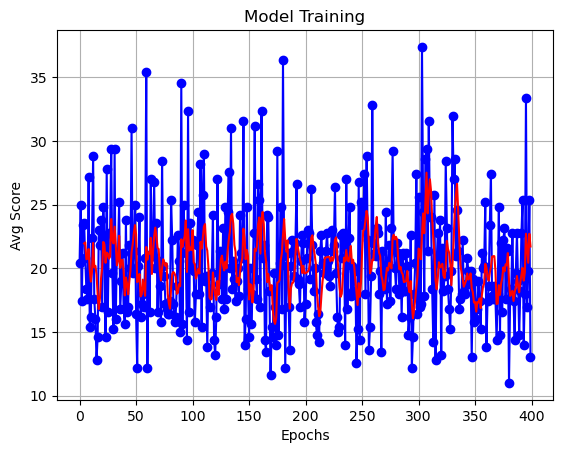

In [107]:
plt.plot(history, marker='o', linestyle='-', color='b')

window_size=5
smoothed_data = np.convolve(history, np.ones(window_size)/window_size, mode='valid')
smoothed_indices = range(window_size - 1, len(history))
plt.plot(smoothed_indices, smoothed_data, marker='', linestyle='-', color='r', label='Smoothed Data')

plt.title("Model Training")
plt.xlabel("Epochs")
plt.ylabel("Avg Score")
# plt.legend()
plt.grid(True)
plt.show()

In [48]:
def test(model,episodes):
    env = gym.make("CartPole-v1",render_mode="human")
    state,info = env.reset()
    state = torch.from_numpy(state)
    total_reward=0
    for ep in range(episodes):
       
        action = torch.argmax(model.forward(state)).item()
        # print(action)
        new_state, reward, done,truncated, info= env.step(action)
        # print(env.step(action))
        total_reward+=reward
        # print(f"{ep} Total reward:",total_reward)
        if done or truncated:
            print(total_reward)
            break
        state = torch.from_numpy(new_state)    
    env.close()
        

In [49]:
for i in range(20):
    print(i)
    test(model_P,100)

0
9.0
1
9.0
2
9.0
3
9.0
4
10.0
5
10.0
6


KeyboardInterrupt: 